In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from scipy import stats
from statsmodels.stats.multitest import multipletests
from datetime import datetime

### Initialize

In [2]:
# Initialize directory if exists
outdir = '../output/IgG_traj_cat'
if os.path.isdir(outdir):
    shutil.rmtree(outdir)
os.mkdir(outdir)

# Create object
os.chdir('classes')
%run longit.ipynb
ecf = LONGIT()
os.chdir('..')

### Load EC50 file and process it

In [3]:
ec50_file = '../input/ec50_values.xlsx'
ecf.loadfiletodf(ec50_file)

# Remove useless columns
col_2_del =['Notes','run1_description','run1_date','run1_1/EC50','run2_date','run2_description',
            'run2_1/EC50','(run1_1/EC50)/(run2_1/EC50)','Sample#']
df_1 = ecf.df.drop(columns=col_2_del)
df_1 = df_1.rename(columns={"sampleID_onset_080620": "sampleID_onset"})

# Remove samples with missing elements
df_missing, df_2 = ecf.samples_with_missing_elements(df_1)
display(df_missing)

# Reformat onset
df_3 = ecf.reformat_onset(df_2)

# Remove samples where EC50 dissagree by more than x
thresh = 3
df4_incoherent, df4 = ecf.incoherent_ec50(df_3, thresh)

# Transform data for plotting
df5 = ecf.transform_df_for_plotting(df4, 'Pt#', 'sampleID_onset', 'average_EC50')
df5.to_excel(outdir + '/' + 'ec50_df.xlsx' )
df5_win = ecf.average_EC50_slidingWindow(df5, 2)
df5_winlog = -np.log10(df5_win)
df5_winlog.to_excel(outdir + '/' + 'EC50_df_window5_minuslog10.xlsx')

,Pt#,run1_EC50,run2_EC50,sampleID,sampleID_onset
111,24.0,NaN,NaN,24-40,24-43
1057,147.0,NaN,NaN,1057,NaN


In [4]:
# Remove patients with less than 7 days worth of readouts (4 readouts)
f = open(outdir + '/' + 'patients_with_poor_coverage.txt', 'w')
df6 = pd.DataFrame()
for patient, row in df5.iterrows():
    firstday = 1000
    lastday = 0
    for day, val in row.iteritems():
#         print(patient, '\t', day, '\t', val)
        if np.isnan(val):
            continue
        if int(day) < firstday:
            firstday = day
        if int(day) > lastday:
            lastday = day
    len_stay = lastday - firstday + 1
    if len_stay < 7:
        print('Removing patient: ', patient, sep='\t')
        print(patient, file=f)
        continue
#     print(patient, firstday, lastday, len_stay)
#     display(df5.loc[[patient]])
    df6 = df6.append(df5.loc[[patient]], ignore_index=False)
print('rows: {}\tcolumns:{}'.format(df6.shape[0], df6.shape[1]))
df6.to_excel(outdir + '/' + 'ec50_df_clean.xlsx')
# display(df6)
f.close()

Removing patient: 	10.0
Removing patient: 	11.0
Removing patient: 	20.0
Removing patient: 	67.0
Removing patient: 	122.0
Removing patient: 	130.0
Removing patient: 	131.0
Removing patient: 	132.0
Removing patient: 	134.0
Removing patient: 	142.0
Removing patient: 	143.0
Removing patient: 	148.0
Removing patient: 	150.0
Removing patient: 	157.0
Removing patient: 	172.0
Removing patient: 	192.0
Removing patient: 	195.0
rows: 130	columns:54


In [5]:
# Use a sliding window to average EC50 values
df6_win = ecf.average_EC50_slidingWindow(df6, 2)

# Log transform
df7 = -np.log10(df6)
df7_win = -np.log10(df6_win)
df6.to_excel(outdir + '/' + 'ec50_df_clean_average_log.xlsx')

### Histogram 

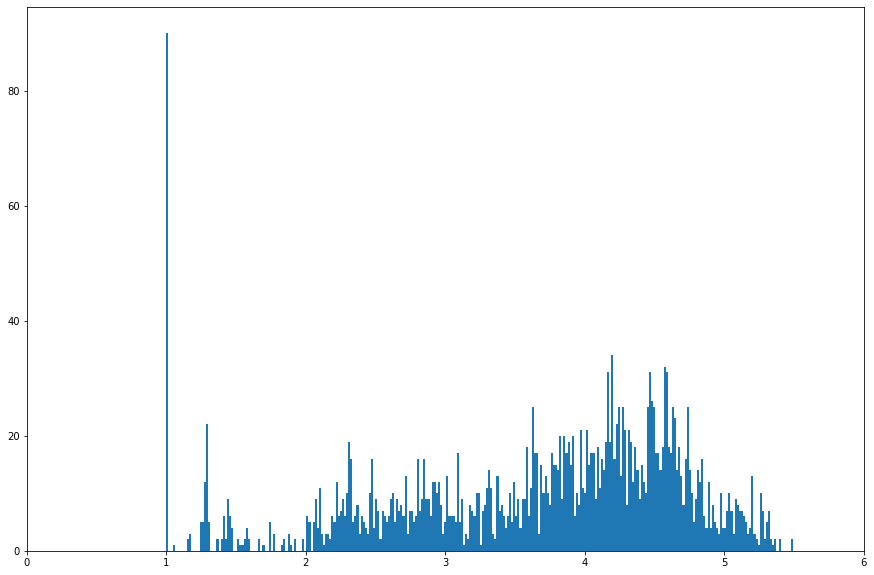

In [6]:
#get values into a list for histogram
ec50_ls = np.array(df7_win.values.tolist())
ec50_ls = ec50_ls[np.logical_not(np.isnan(ec50_ls))]

plt.figure(figsize=(15,10))
ar = plt.hist(ec50_ls, bins=300)
plt.xlim(0,6)
plt.savefig(outdir + '/' + 'ec50_histogram.pdf', dpi=300)
# plt.show

### Use percentiles as thresholds to split responses into low, medium and high

In [7]:
f = open(outdir + '/' + 'percentiles.txt', 'w')
perc10 = np.percentile(ec50_ls, 10)
perc25 = np.percentile(ec50_ls, 25)
perc50 = np.percentile(ec50_ls, 50)
perc75 = np.percentile(ec50_ls, 75)
perc90 = np.percentile(ec50_ls, 90)
print(perc25, perc75, sep='\t')
print('Percentile 10:', perc10, sep='\t', file=f)
print('Percentile 25:', perc25, sep='\t', file=f)
print('Percentile 50:', perc50, sep='\t', file=f)
print('Percentile 75:', perc75, sep='\t', file=f)
print('Percentile 90:', perc90, sep='\t', file=f)
f.close()

2.9107728093338596	4.467627866432123


### Split responses

In [8]:
f = open(outdir + '/' + 'IgG_response.txt', 'w')
sustain_thresh = 5 #These are number of days
interf_thresh = 2 #These are number of days
low_res = []
med_res = []
high_res = []
med_high_res = []
low_med_res = []
low_high_res = []

for patient, row in df7_win.iterrows():
    print(patient, file=f)
    low_sustain = 0
    is_low = False
    med_sustain = 0
    is_med = False
    high_sustain = 0
    is_high = False
    prev_val = np.nan
    for day, val in row.iteritems():
        if np.isnan(val):
            continue
        if val > perc75:
            med_sustain = 0
            low_sustain = 0
            if (np.isnan(prev_val)) or (prev_val < perc75):
                high_sustain = 1
            else:
                high_sustain += 1
#             print('\thigh', val, high_sustain, sep='\t')
            if high_sustain >= sustain_thresh:
                is_high = True
#                 break
        elif val > perc25 and val <= perc75:
            high_sustain = 0
            low_sustain = 0
            if (np.isnan(prev_val)) or (prev_val < perc25):
                med_sustain = 1
            else:
                med_sustain += 1
            if med_sustain >= sustain_thresh:
                is_med = True
        else:
            low_sustain += 1
            high_sustain = 0
            med_sustain = 0
            if low_sustain >= sustain_thresh:
                is_low = True

        print('\t',day, val, low_sustain, med_sustain, high_sustain, is_low, is_med, is_high, sep= '\t', file=f)
        prev_val = val
    if is_high == True:
        if med_sustain < interf_thresh:
            high_res.append(patient)
            print('\t','high', file=f)
        else:
            med_high_res.append(patient)
            print('\t','medium-high', file=f)
    elif is_med == True:
        if high_sustain < interf_thresh:
            med_res.append(patient)
            print('\t','medium', file=f)
        else:
            med_high_res.append(patient)
            print('\t','medium-high', file=f)
    else:
        if med_sustain < interf_thresh and high_sustain < interf_thresh:
            low_res.append(patient)
            print('\t','low', file=f)
        else:
            if med_sustain >= interf_thresh:
                low_med_res.append(patient)
                print('\t','low-medium', file=f)
            else:
                low_high_res.append(patient)
                print('\t','low-high', file=f)                
        
f.close()
f = open(outdir + '/' + 'IgG_response_categories.txt', 'w')
print('low response', len(low_res), sep='\t')
[print('Low_response',item, file=f) for item in low_res]
print('low-medium response', len(low_med_res), sep='\t')
[print('Low_medium_response',item, file=f) for item in low_med_res]
print('low-high response', len(low_high_res), sep='\t')
[print('Low_high_response',item, file=f) for item in low_high_res]
print('medium response', len(med_res), sep='\t')
[print('Medium_response',item, file=f) for item in med_res]
print('medium-high response', len(med_high_res), sep='\t')
[print('Medium_high_response',item, file=f) for item in med_high_res]
print('high response', len(high_res), sep='\t')
[print('High_response',item, file=f) for item in high_res]
f.close()

low response	15
low-medium response	2
low-high response	2
medium response	59
medium-high response	17
high response	35


### Parse categorized responses into separate dataframes for plotting 

In [9]:
df7_win_low = pd.DataFrame()
df7_win_med = pd.DataFrame()
df7_win_high = pd.DataFrame()
df7_win_low_med = pd.DataFrame()
df7_win_low_high = pd.DataFrame()
df7_win_med_high = pd.DataFrame()
for patient in low_res:
    df7_win_low = df7_win_low.append(df7_win.loc[[patient]], ignore_index=False)
for patient in med_res:
    df7_win_med = df7_win_med.append(df7_win.loc[[patient]], ignore_index=False)    
for patient in high_res:
    df7_win_high = df7_win_high.append(df7_win.loc[[patient]], ignore_index=False)    
for patient in low_med_res:
    df7_win_low_med = df7_win_low_med.append(df7_win.loc[[patient]], ignore_index=False)    
for patient in low_high_res:
    df7_win_low_high = df7_win_low_high.append(df7_win.loc[[patient]], ignore_index=False)   
for patient in med_high_res:
    df7_win_med_high = df7_win_med_high.append(df7_win.loc[[patient]], ignore_index=False)   

### Plot EC50 trajectories by category

In [10]:
def plot_ec50(df, outfile, xmax, ymax, col):
    label_font = {'fontname':'Helvetica Neue', 'fontsize':16}
    axis_font = {'fontname':'Helvetica Neue', 'fontsize':16}
    legend_font = {'fontname':'Helvetica Neue', 'fontsize':18}
    f,ax = plt.subplots(figsize=(15,10))
    col_ar = np.array(df.columns)
    for patient, row in df.iterrows():
        val_ar = np.asarray(row.values.tolist())
        col_clean = col_ar[np.isfinite(val_ar)]
        val_clean = val_ar[np.isfinite(val_ar)]
        plt.plot(col_clean, val_clean,'o-', label=patient, color=col)
        plt.ylim(0, ymax)
        plt.xlim(0, xmax)

    label_font = {'fontname':'Helvetica Neue', 'fontsize':16}
    axis_font = {'fontname':'Helvetica Neue', 'fontsize':16}
    legend_font = {'fontname':'Helvetica Neue', 'fontsize':18}
    title_font = {'fontname':'Helvetica Neue', 'fontsize':20}
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1) 
    plt.ylabel('-log10(EC50)')
    plt.xlabel('Days after onset') 
    plt.xlim(0,61)
    plt.grid(b=False, which='both', axis='y')
    plt.savefig(outfile, dpi=300, transparent=True)
    plt.show

In [11]:
%%capture
plot_ec50(df7_win_low, outdir + '/' + 'low_response.pdf', 90, 6, '#626567')
plot_ec50(df7_win_low_med, outdir + '/' + 'low_med_response.pdf', 90, 6, '#9B59B6')
plot_ec50(df7_win_low_high, outdir + '/' + 'low_high_response.pdf', 90, 6, '#9B59B6')
plot_ec50(df7_win_med, outdir + '/' + 'medium_response.pdf', 90, 6, '#5499C7')
plot_ec50(df7_win_med_high, outdir + '/' + 'med_high_response.pdf', 90, 6, '#D4AC0D')
plot_ec50(df7_win_high, outdir + '/' + 'high_response.pdf', 90, 6, '#CD6155')